###  Какие показатели RoAS[n], CPA[n] (n = 1, 3, 7, 30 дней) нужны для того, чтобы трафик окупился на 100% на 365-ый день (RoAS[365] = 1) в каждом из сегментов B0 … B12?

Концептуально: мы можем [попробовать аппроксимировать функцию](#roas_predict) RoAS[n], сделать предикт при $n = 365$ и посмотреть на значение предсказания относительно желаемого значения. Таким образом, показатели нужны такие, чтобы предсказания были > 1, и кроме того, для такого прогноза следует построить доверительный интервал, и если и в него 1 не попадает, то мы сможем быть уверены в своем прогнозе при условии хорошей модели. Кроме того, хорошо было бы добавить сюда фактор инфляции, но для простоты опустим его.

###  Какое количество инсталлов или платящих игроков Вы бы назвали достаточным для принятия решения, что трафик окупается / не окупается в каждом из сегментов по каждой из метрик (RoAS[n], CPA[n])?

Для RoAS - никакое :) Мы не можем рассуждать об окупаемости трафика, не учитывая затрат на него, а если учитывать CPI, то вопрос сведется к предыдущему пункту. 

Окупаемость по CPA можно определить так: трафик окупается по CPA для юзеров в течение первых n дней игры, если среднее revenue с платящего юзера в течение первых n дней игры (ARPPU_n) больше, чем CPA.
В простейшем случае (если нас интересует окупаемость в моменте) мы можем просто [посмотреть графики](#cpa_revenue) CPA_n и ARPPU_n и увидеть, есть ли уже окупаемость. Если нас интересует окупаемость, к примеру, через год, то мы можем поступить так же, как в первом случае - зафитить кривые под обе функции и сравнить предсказания через год, взяв нижнее значение доверительного интервала для ARPPU для уверенности.

Отвечая на вопрос про количество $x$ платящих игроков для момента $n$: для окупаемости нам нужен $x$ такой, что $CPA_n = \frac{CPI}{x} < ARPPU_n$. Таким образом, достаточно взять $x > \frac{CPI}{ARPPU_n}$.

###  Что мы могли скрыть под feature_X?

Каналы для рекламы трафика (реклама в различных приложениях/сервисах, типа Youtube ads, Facebook ads, карусель новинок в каком-нибудь игровом агрегаторе и тд).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from tqdm.auto import tqdm

tqdm.pandas()
from sklearn.metrics import r2_score
import gc
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext nb_black

PATH_DATA = "../data/"

features = [
    "B0",
    "B1",
    "B2",
    "B3",
    "B4",
    "B5",
    "B6",
    "B7",
    "B8",
    "B9",
    "B10",
    "B11",
    "B12",
]

M:\Anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


<IPython.core.display.Javascript object>

In [2]:
from scipy import stats


def predband(x, xd, yd, p, func, conf=0.95):
    # x = requested points
    # xd = x data
    # yd = y data
    # p = parameters
    # func = function name
    alpha = 1.0 - conf  # significance
    N = xd.size  # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1.0 / (N - var_n) * np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0 + (1.0 / N) + (sx / sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

<IPython.core.display.Javascript object>

In [3]:
%%time

df_purchases = pd.read_csv(PATH_DATA + "purchases.csv", header=None)
df_users = pd.read_csv(PATH_DATA + "users.csv", header=None)

df_purchases.columns = ["id", "buy_time", "revenue"]
df_users.columns = ["id", "reg_time", "feature_X", "cpi"]

df_purchases = df_purchases.sort_values(by=["id", "buy_time"]).reset_index(drop=True)

df_purchases["buy_time_day"] = df_purchases["buy_time"].apply(lambda x: x.split(" ")[0])
df_users["reg_time_day"] = df_users["reg_time"].apply(lambda x: x.split(" ")[0])

df_users["reg_time"] = pd.to_datetime(df_users["reg_time"])
df_purchases["buy_time"] = pd.to_datetime(df_purchases["buy_time"])

df_purchases = df_purchases.merge(df_users[["id", "reg_time", "reg_time_day", 'feature_X']], how="left", on="id")
df_purchases["buy_time_reg_days_diff"] = (
        df_purchases["buy_time"] - df_purchases["reg_time"]
    )
df_purchases["buy_time_reg_days_diff"] = df_purchases["buy_time_reg_days_diff"].apply(lambda x: x.days)

cur_end_of_campaign = pd.to_datetime('2020-12-31 00:00:00')
df_users["reg_time_and_cur_end_of_campaign_days_diff"] = (
        cur_end_of_campaign - df_users["reg_time"]
    )
df_users["reg_time_and_cur_end_of_campaign_days_diff"] = df_users["reg_time_and_cur_end_of_campaign_days_diff"].apply(lambda x: x.days)

Wall time: 20.4 s


<IPython.core.display.Javascript object>

In [4]:
df_purchases.head()

,id,buy_time,revenue,buy_time_day,reg_time,reg_time_day,feature_X,buy_time_reg_days_diff
0,000030de0b52e478c151604e7b8c825d,2020-10-14 18:22:05,6.45256,2020-10-14,2020-10-10 13:30:36,2020-10-10,B6,4
1,00044b96dc703d4736a5a167adc1a88f,2020-09-03 02:40:44,1.99000,2020-09-03,2020-08-31 02:50:57,2020-08-31,B0,2
2,00044b96dc703d4736a5a167adc1a88f,2020-09-04 03:48:18,0.99000,2020-09-04,2020-08-31 02:50:57,2020-08-31,B0,4
3,00044b96dc703d4736a5a167adc1a88f,2020-09-04 15:35:21,0.99000,2020-09-04,2020-08-31 02:50:57,2020-08-31,B0,4
4,00044b96dc703d4736a5a167adc1a88f,2020-09-04 21:37:54,0.99000,2020-09-04,2020-08-31 02:50:57,2020-08-31,B0,4


<IPython.core.display.Javascript object>

In [5]:
df_users.head()

,id,reg_time,feature_X,cpi,reg_time_day,reg_time_and_cur_end_of_campaign_days_diff
0,a1f3165713e2609ccfa94ac152745de9,2020-08-10 16:13:40,B10,0.68,2020-08-10,142
1,65b3c06b73746ce96c985b2de163cb30,2020-08-10 16:14:11,B0,11.45,2020-08-10,142
2,053713745bc236aaabeaeda33935f4e2,2020-08-10 16:14:49,B8,4.24,2020-08-10,142
3,1fdec2d9affbab8b6c5d357f1e3a4e06,2020-08-10 16:15:19,B0,10.82,2020-08-10,142
4,9f6fe54133cf4bcb55442499453d6e42,2020-08-10 16:16:44,B0,5.82,2020-08-10,142


<IPython.core.display.Javascript object>

In [6]:
df_purchases.shape, df_users.shape

((839832, 8), (973944, 6))

<IPython.core.display.Javascript object>

In [7]:
df_purchases.isnull().sum()

id                        0
buy_time                  0
revenue                   0
buy_time_day              0
reg_time                  0
reg_time_day              0
feature_X                 0
buy_time_reg_days_diff    0
dtype: int64

<IPython.core.display.Javascript object>

In [8]:
df_users.isnull().sum()

id                                            0
reg_time                                      0
feature_X                                     0
cpi                                           0
reg_time_day                                  0
reg_time_and_cur_end_of_campaign_days_diff    0
dtype: int64

<IPython.core.display.Javascript object>

#### Посмотрим, что у нас за данные.

In [9]:
df_purchases["buy_time_day"].nunique(), df_users["reg_time_day"].nunique()

(143, 83)

<IPython.core.display.Javascript object>

In [10]:
df_purchases["buy_time_day"].min(), df_purchases["buy_time_day"].max()

('2020-08-10', '2020-12-30')

<IPython.core.display.Javascript object>

In [11]:
df_users["reg_time_day"].min(), df_users["reg_time_day"].max()

('2020-08-10', '2020-10-31')

<IPython.core.display.Javascript object>

In [12]:
df_purchases["id"].value_counts()

8aa615ed2180d9a5a8e09d58839ffb07    1976
860e52794667f95f3bd904427f3cf3e1    1583
a2c423f3a4eaedba391ddc62c13b2572    1469
dcaf02143a35df74066e1bc652559702    1223
bfeb98a79982f1952052030810857e5f    1201
                                    ... 
ed65fcb8cdc73e18705eb622a62c130f       1
f6e21aeaffabf5f1a597fb424a54f593       1
f751a07c3f87c3f180d8680d06a51133       1
2369f4d90c5103fe6c223b06116685d1       1
6a24739cdfb95d6df21b938abf135354       1
Name: id, Length: 41061, dtype: int64

<IPython.core.display.Javascript object>

In [13]:
df_users["id"].value_counts()

b9f9336c6af487bb9f8f1c02f332112d    1
3cfcd668123a6785a45c38575217f022    1
3b7956999fb88a7e2ea2bb0ca8f4658d    1
1982ddbb3d724c966df28d38529133b9    1
ce1ba1134fc853f4058cbc2cc7bf65a1    1
                                   ..
c0c278a45bceac7e7c60e09ff45657fc    1
db3563209473a60bf9c12a7fd9c52170    1
7317f70e51b83c48d95726db3cca78ef    1
aba145dcfdafb26c252ef6abd8a2234a    1
1cddb109c88030d0b71a5db7ea1ffb9a    1
Name: id, Length: 973944, dtype: int64

<IPython.core.display.Javascript object>

In [14]:
df_users_feature_stats = (
    df_users.groupby("feature_X")[["id", "cpi"]]
    .agg({"id": ["count"], "cpi": ["mean", "median"]})
    .reset_index()
    .sort_values(("id", "count"), ascending=False)
    .reset_index(drop=True)
)

df_users_feature_stats

feature_X      id       cpi       
               count      mean median
0         B0  471283  9.838772   8.73
1         B3  111817  2.206681   1.68
2        B10   55976  1.922740   1.66
3         B6   49233  3.893421   3.44
4         B5   47604  0.939824   0.79
5         B8   42174  3.835697   3.29
6         B7   41230  4.528985   4.03
7         B2   34932  1.823320   1.28
8         B9   28820  4.543666   3.89
9        B11   26785  0.510542   0.36
10        B1   26184  7.241239   6.56
11        B4   24050  1.066542   0.85
12       B12   13856  1.275499   1.05

<IPython.core.display.Javascript object>

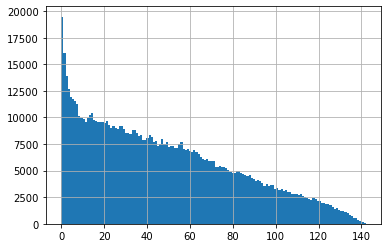

<IPython.core.display.Javascript object>

In [15]:
df_purchases["buy_time_reg_days_diff"].hist(
    bins=df_purchases["buy_time_reg_days_diff"].nunique()
)

Итак, у нас есть когорты от 60 дней до 140 дней истории. Гарантированно все имеют 60 дней истории, с ними и будем работать.

In [16]:
%%time

df_purchases_gp = (
    df_purchases.groupby(["id", "buy_time_reg_days_diff"])[["revenue"]]
    .sum()
    .reset_index()
)

df_gp = pd.DataFrame()
df_gp["id"] = list(set(df_purchases_gp["id"]))
days_list = sorted(list(set(df_purchases_gp["buy_time_reg_days_diff"])))
df_gp["buy_time_reg_days_diff_template"] = [days_list for _ in range(len(df_gp))]
df_gp = df_gp.explode("buy_time_reg_days_diff_template")
df_purchases_gp = df_gp.merge(
    df_purchases_gp,
    how="left",
    left_on=["id", "buy_time_reg_days_diff_template"],
    right_on=["id", "buy_time_reg_days_diff"],
)

del df_gp, days_list
gc.collect()

df_purchases_gp = df_purchases_gp.drop(["buy_time_reg_days_diff"], axis=1)
df_purchases_gp = df_purchases_gp.rename(
    {"buy_time_reg_days_diff_template": "buy_time_reg_days_diff"}, axis=1
)
df_purchases_gp["revenue"] = df_purchases_gp["revenue"].fillna(0)
df_purchases_gp = df_purchases_gp.merge(
    df_users[["id", "feature_X", "reg_time"]], on="id", how="left"
)

last_purchase_of_df = df_purchases["buy_time"].max()
df_purchases_gp["last_purchase_of_df_and_reg_time_days_diff"] = (
    last_purchase_of_df - df_purchases_gp["reg_time"]
)
df_purchases_gp["last_purchase_of_df_and_reg_time_days_diff"] = df_purchases_gp[
    "last_purchase_of_df_and_reg_time_days_diff"
].progress_apply(lambda x: x.days)

cur_len_df = df_purchases_gp.shape[0]
df_purchases_gp = df_purchases_gp[
    df_purchases_gp["last_purchase_of_df_and_reg_time_days_diff"]
    >= df_purchases_gp["buy_time_reg_days_diff"]
].reset_index(drop=True)

df_purchases_gp['revenue_cumsum'] = df_purchases_gp.groupby(["id"])["revenue"].cumsum()

print('len_df:', cur_len_df, '->', df_purchases_gp.shape[0])

df_purchases_gp.head()


len_df: 5871723 -> 4491473
Wall time: 57 s


,id,buy_time_reg_days_diff,revenue,feature_X,reg_time,last_purchase_of_df_and_reg_time_days_diff,revenue_cumsum
0,6a24739cdfb95d6df21b938abf135354,0,0.0,B1,2020-08-30 09:00:52,122,0.0
1,6a24739cdfb95d6df21b938abf135354,1,0.0,B1,2020-08-30 09:00:52,122,0.0
2,6a24739cdfb95d6df21b938abf135354,2,0.0,B1,2020-08-30 09:00:52,122,0.0
3,6a24739cdfb95d6df21b938abf135354,3,0.0,B1,2020-08-30 09:00:52,122,0.0
4,6a24739cdfb95d6df21b938abf135354,4,0.0,B1,2020-08-30 09:00:52,122,0.0


<IPython.core.display.Javascript object>

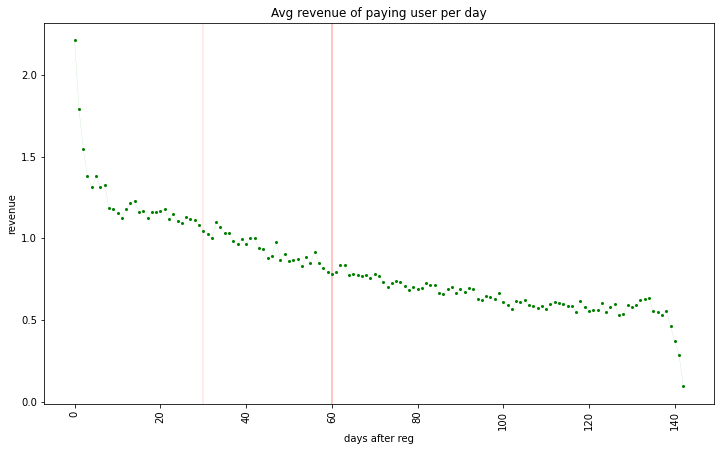

<IPython.core.display.Javascript object>

In [17]:
xs = sorted(list(set(df_purchases_gp["buy_time_reg_days_diff"])))
ys = (
    df_purchases_gp.groupby("buy_time_reg_days_diff")[["revenue"]]
    .mean()
    .reset_index()["revenue"]
)

plt.figure(figsize=(12, 7))
plt.axvline(x=30, color="r", linestyle="-", alpha=0.1)
plt.axvline(x=60, color="r", linestyle="-", alpha=0.3)
plt.xticks(rotation=90)
plt.title("Avg revenue of paying user per day")
plt.xlabel("days after reg")
plt.ylabel("revenue")
plt.plot(
    xs, ys, color="green", marker="o", linestyle="dashed", linewidth=0.1, markersize=2
)

Как видим, со временем величина донатов падает.

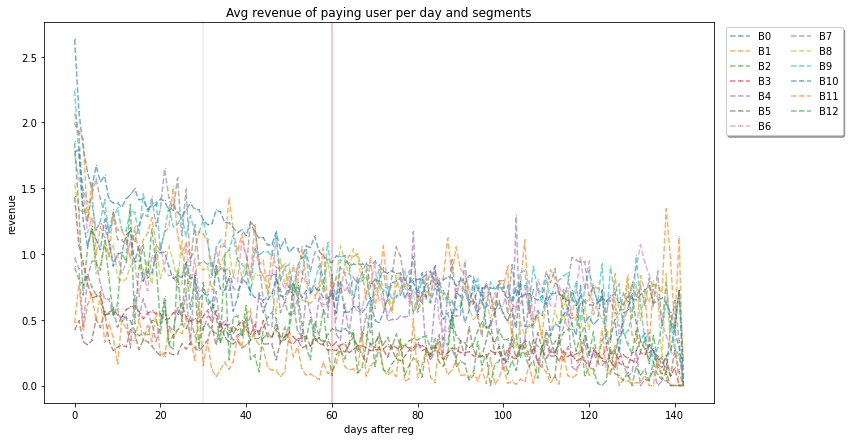

<IPython.core.display.Javascript object>

In [18]:
dict_revenues = dict()
for feature, cur_df in df_purchases_gp.groupby("feature_X"):
    ys = (
        cur_df.groupby("buy_time_reg_days_diff")[["revenue"]]
        .mean()
        .reset_index()["revenue"]
    )
    dict_revenues[feature] = ys

plt.figure(figsize=(12, 7))
plt.title("Avg revenue of paying user per day and segments")
plt.xlabel("days after reg")
plt.ylabel("revenue")

xs = sorted(list(set(df_purchases_gp["buy_time_reg_days_diff"])))
for feature in features:
    ys = list(dict_revenues[feature])
    plt.plot(
        xs,
        ys,
        label=feature,
        marker=",",
        linestyle="dashed",
        alpha=0.6,
    )
plt.axvline(x=30, color="r", linestyle="-", alpha=0.1)
plt.axvline(x=60, color="r", linestyle="-", alpha=0.3)
plt.legend(
    loc="upper right", bbox_to_anchor=(1.2, 1.0), ncol=2, fancybox=True, shadow=True
)

In [19]:
#  RoAS[n] = RPI[n] / CPI, где RPI[n] - средний платеж пользователя за первые n
# дней игры, а CPI - средняя цена привлечения пользователя
#  CPA[n] = CPI / C2P[n], где C2P[n] - доля пользователей, заплативших cколько
# угодно >0 в течение первых n дней игры


def get_metrics_n(feature="B0", n=7, df_purchases=df_purchases, df_users=df_users):
    cur_df_users = df_users[
        (df_users["feature_X"] == feature)
        & (df_users["reg_time_and_cur_end_of_campaign_days_diff"] >= n)
    ]

    cur_df_purchases = df_purchases.merge(cur_df_users[["id"]], how="inner", on="id")

    cur_df_purchases_n_days_after_reg = cur_df_purchases[
        cur_df_purchases["buy_time_reg_days_diff"] < n
    ]

    if len(cur_df_purchases_n_days_after_reg) == 0:
        return 0, 0, 0

    revenue_sum = cur_df_purchases_n_days_after_reg["revenue"].sum()
    n_users = cur_df_users["id"].nunique()
    n_users_paid = cur_df_purchases_n_days_after_reg["id"].nunique()

    RPI_n = revenue_sum / n_users
    CPI = cur_df_users["cpi"].mean()
    C2P_n = n_users_paid / n_users

    RoAS_n = RPI_n / CPI
    ARPPU_n = revenue_sum / n_users_paid
    CPA_n = CPI / C2P_n

    return RoAS_n, CPA_n, ARPPU_n

<IPython.core.display.Javascript object>

In [20]:
%%time

days = np.arange(0, 61)

dict_roases = dict()
dict_cpas = dict()
dict_arppus = dict()
for feature in tqdm(features):
    dict_roases[feature] = list()
    dict_cpas[feature] = list()
    dict_arppus[feature] = list()
    for n_days in days:
        cur_RoAS, cur_CPA, cur_ARPPU = get_metrics_n(feature=feature, n=n_days)
        dict_roases[feature].append(cur_RoAS)
        dict_cpas[feature].append(cur_CPA)
        dict_arppus[feature].append(cur_ARPPU)


Wall time: 2min 53s


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'RoAS')

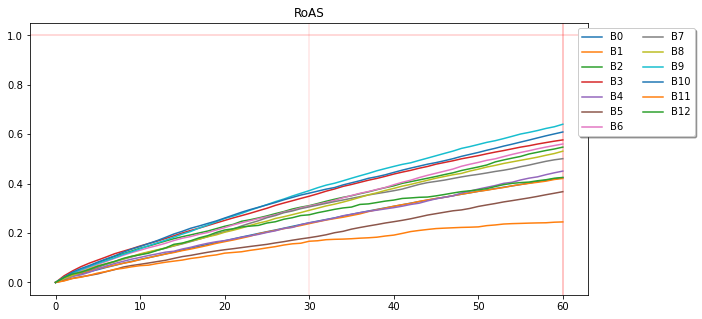

<IPython.core.display.Javascript object>

In [21]:
plt.figure(figsize=(10, 5))
plt.axvline(x=30, color="r", linestyle="-", alpha=0.1)
plt.axvline(x=60, color="r", linestyle="-", alpha=0.3)
plt.axhline(y=1.0, color="r", linestyle="-", alpha=0.2)
for feature in dict_roases.keys():
    ydata = dict_roases[feature]
    plt.plot(days, ydata, label=feature)
plt.legend(
    loc="upper right", bbox_to_anchor=(1.2, 1.0), ncol=2, fancybox=True, shadow=True
)
plt.title("RoAS")

Text(0.5, 1.0, 'ARPPU')

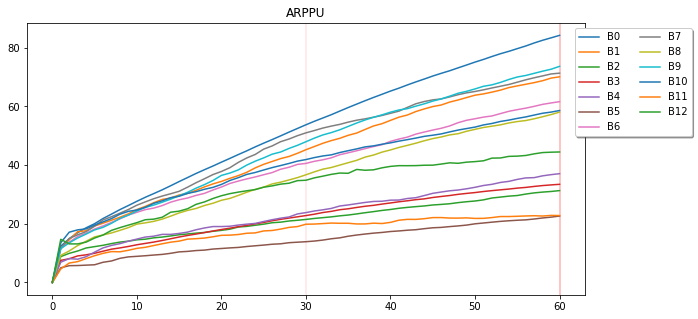

<IPython.core.display.Javascript object>

In [22]:
plt.figure(figsize=(10, 5))
plt.axvline(x=30, color="r", linestyle="-", alpha=0.1)
plt.axvline(x=60, color="r", linestyle="-", alpha=0.3)
for feature in dict_arppus.keys():
    ydata = dict_arppus[feature]
    plt.plot(days, ydata, label=feature)
plt.legend(
    loc="upper right", bbox_to_anchor=(1.2, 1.0), ncol=2, fancybox=True, shadow=True
)
plt.title("ARPPU")

Text(0.5, 1.0, 'CPA')

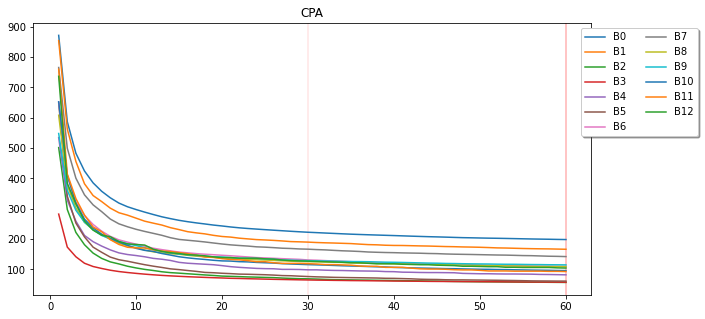

<IPython.core.display.Javascript object>

In [23]:
plt.figure(figsize=(10, 5))
plt.axvline(x=30, color="r", linestyle="-", alpha=0.1)
plt.axvline(x=60, color="r", linestyle="-", alpha=0.3)
for feature in dict_cpas.keys():
    ydata = dict_cpas[feature]
    plt.plot(days[1:], ydata[1:], label=feature)
plt.legend(
    loc="upper right", bbox_to_anchor=(1.2, 1.0), ncol=2, fancybox=True, shadow=True
)
plt.title("CPA")

Графики CPA_n и ARPPU_n.
<a id='cpa_revenue'></a>

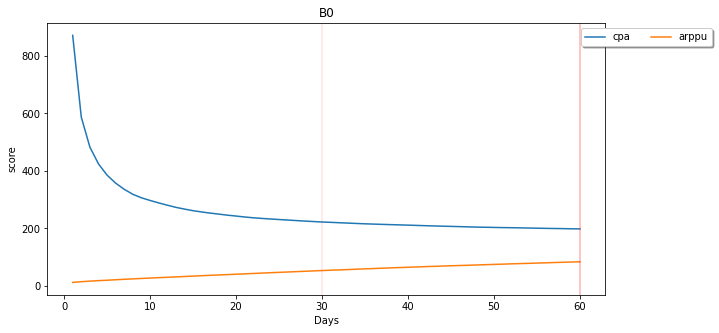

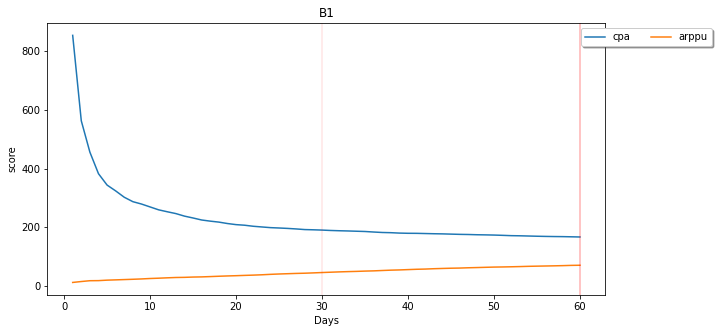

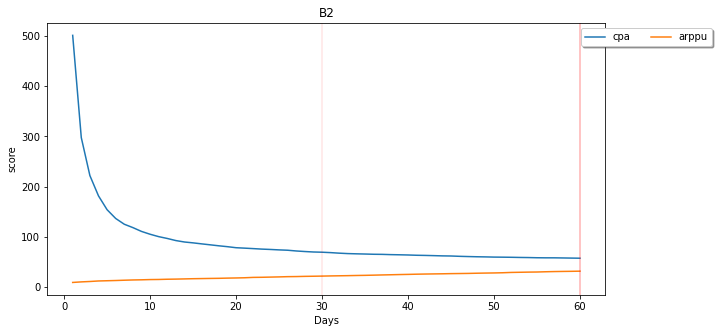

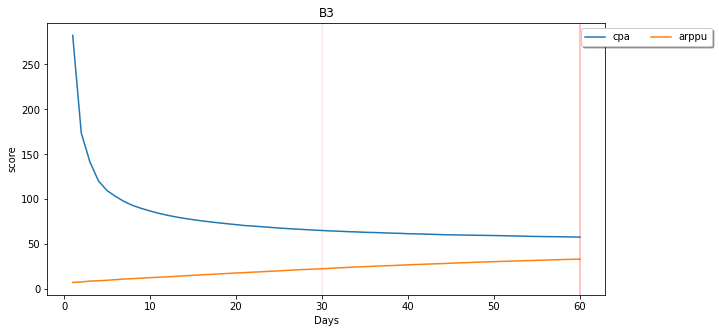

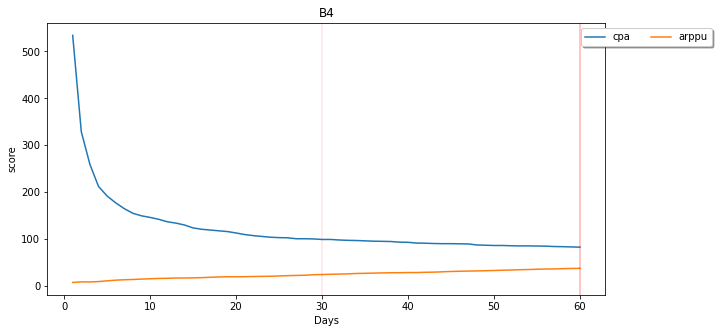

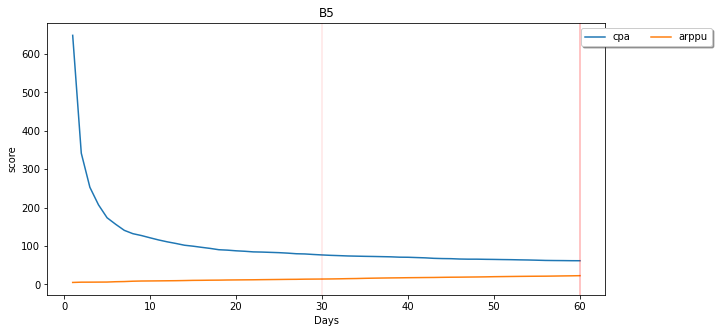

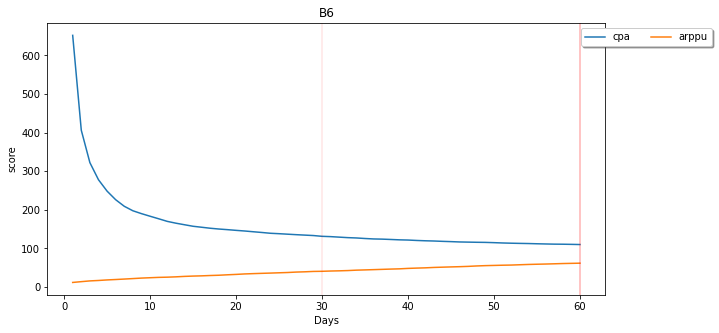

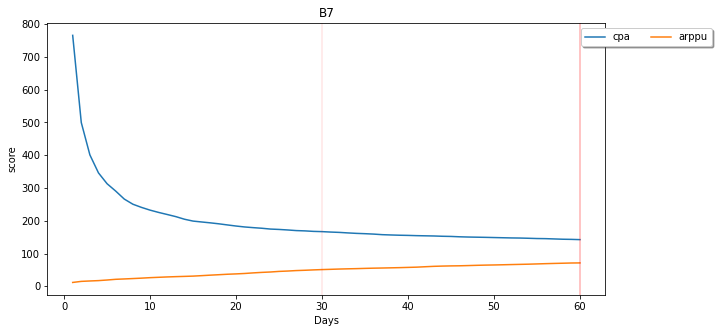

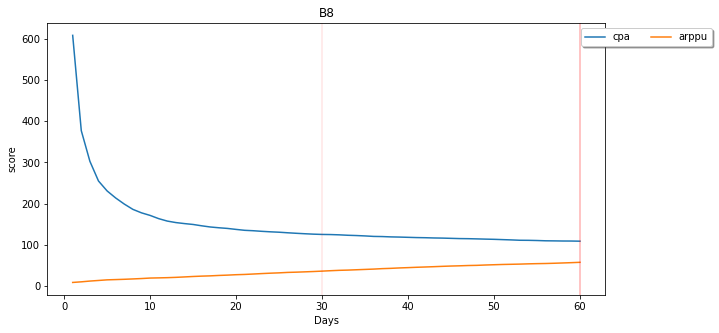

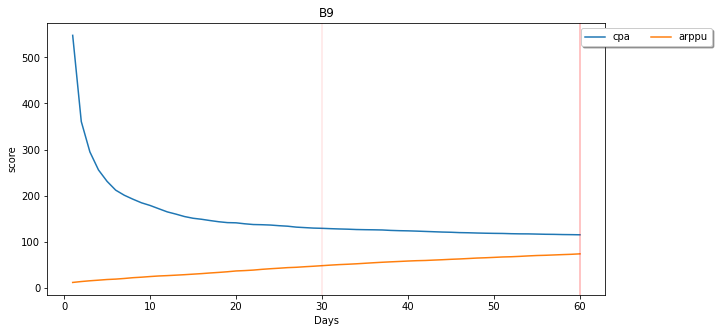

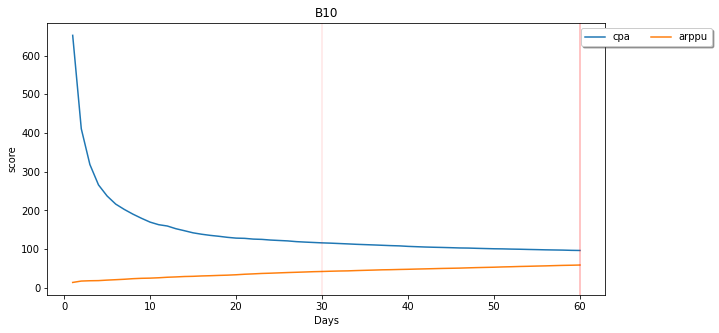

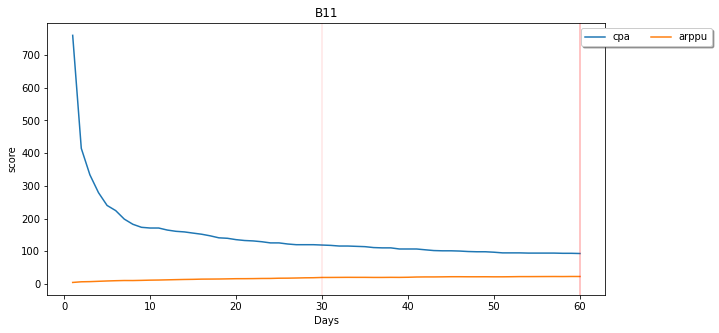

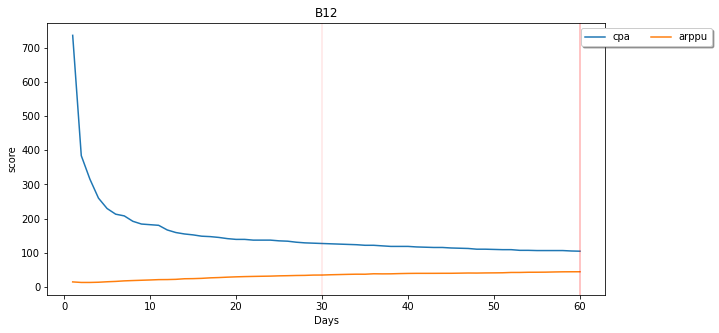

<IPython.core.display.Javascript object>

In [24]:
for feature in dict_cpas.keys():
    plt.figure(figsize=(10, 5))

    ydata = dict_cpas[feature]
    plt.plot(days[1:], ydata[1:], label="cpa")

    ydata = dict_arppus[feature]
    plt.plot(days[1:], ydata[1:], label="arppu")

    plt.legend(
        loc="upper right", bbox_to_anchor=(1.2, 1.0), ncol=2, fancybox=True, shadow=True
    )

    plt.axvline(x=30, color="r", linestyle="-", alpha=0.1)
    plt.axvline(x=60, color="r", linestyle="-", alpha=0.3)
    plt.xlabel("Days")
    plt.ylabel("score")
    plt.title(feature)
    plt.show()

In [25]:
def func_log(x, a, b):
    return a * np.log1p(b * x)

<IPython.core.display.Javascript object>

In [26]:
def plot_predictions(
    feature,
    func=func_log,
    train_days_len=31,
    dict_vals=dict_roases,
    idxs_for_train=None,
    desired_value=None,
):

    days_full = np.arange(0, 366)
    days = np.arange(0, 61)
    ydata = dict_vals[feature]

    xs = days[:train_days_len]
    ys = ydata[:train_days_len]

    if idxs_for_train is not None:
        xs = xs[idxs_for_train]
        ys = np.array(ys)[idxs_for_train]

    popt, pcov = curve_fit(
        func,
        xs,
        ys,
        p0=None,
        method="lm",
        maxfev=2000,
    )

    px = days_full  # [train_days_len:]

    lpb, upb = predband(px, xs, ys, popt, func, conf=0.95)

    plt.figure(figsize=(15, 5))

    plt.plot(px, lpb, "k--", alpha=0.2, label="95% Prediction Band")
    plt.plot(px, upb, "k--", alpha=0.2)

    plt.axvline(x=31, color="r", linestyle="-", alpha=0.1)
    plt.axvline(x=61, color="r", linestyle="-", alpha=0.3)
    if desired_value is not None:
        plt.axhline(y=desired_value, color="r", linestyle="-", alpha=0.2)

    predicted = [func(x, *popt) for x in px]
    plt.plot(
        px,
        predicted,
        label="Predicted",
        alpha=0.7,
    )

    plt.plot(
        days,
        ydata,
        label="Ground truth",
        alpha=1.0,
    )

    if idxs_for_train is not None:
        plt.scatter(xs, ys, label="Points for train", alpha=0.3, marker="o", color="g")

    if train_days_len < len(days):
        r2_pred = r2_score(
            ydata[train_days_len : len(days)], predicted[train_days_len : len(days)]
        )
        plt.title(
            f"{feature}, r2 of {train_days_len} to {len(days) - 1} days prediction = {r2_pred}"
        )
    else:
        plt.title(feature)
    plt.xlabel("Days")
    plt.ylabel("score")
    plt.legend(
        loc="upper right", bbox_to_anchor=(1.2, 1.0), ncol=1, fancybox=True, shadow=True
    )
    return predicted, ydata

<IPython.core.display.Javascript object>

Предсказываем RoAS. Для аппроксимации возьмем логарифм-like функцию и выучим нужные параметры. В целом, мы могли бы это делать и на всех точках для дней <= 30, особенно если учесть, что 4 точки - это очень мало для трейна, но если нам почему-то принципиально делать это именно в точках 1, 3, 7, 30, то так тому и быть!

Замерять качество моделек будем на последующем известном нам отрезке от 31-го до 60-го дня, метрикой возьмем r2, чтобы понимать, что-то адекватное мы выучили в итоге или нет.
<a id='roas_predict'></a>

Wall time: 261 ms


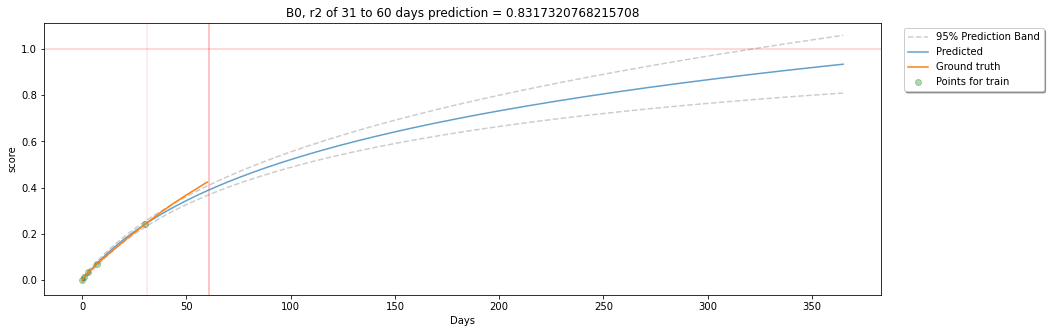

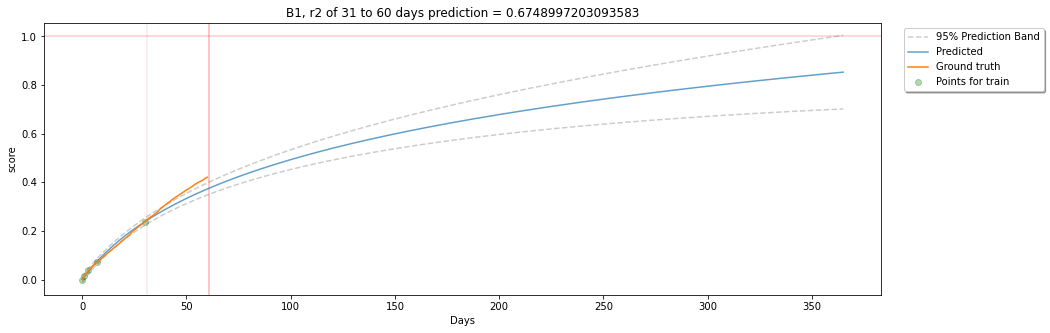

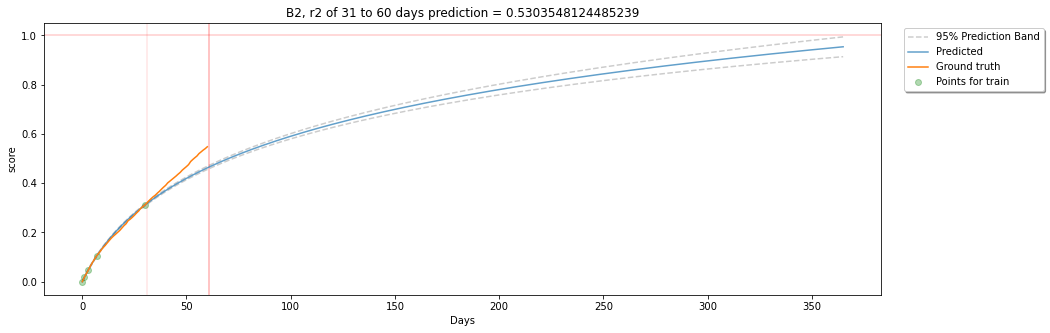

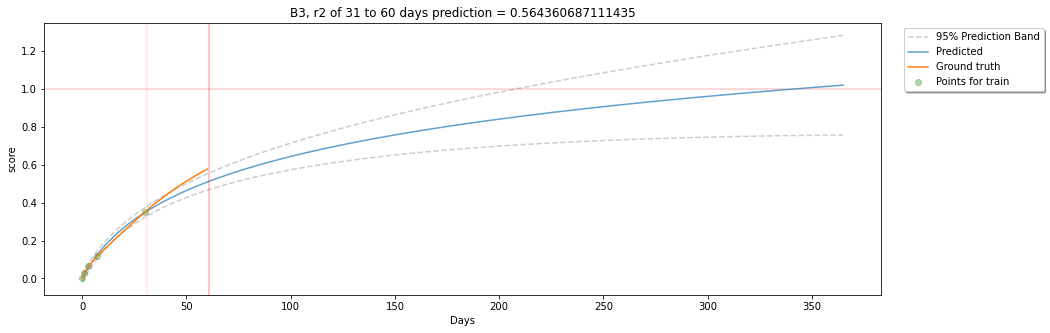

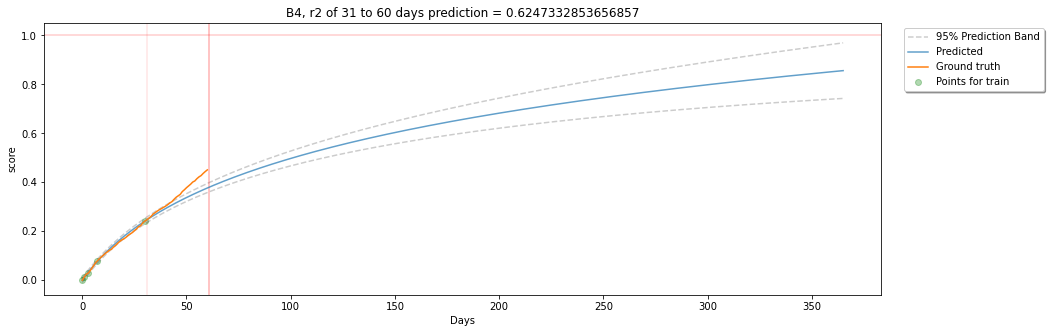

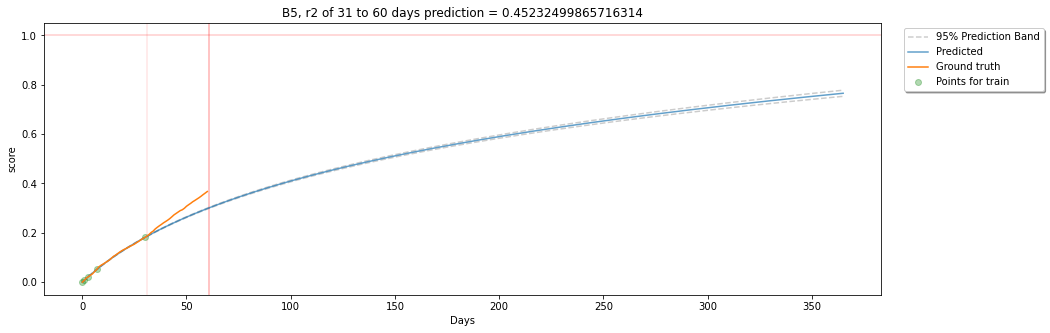

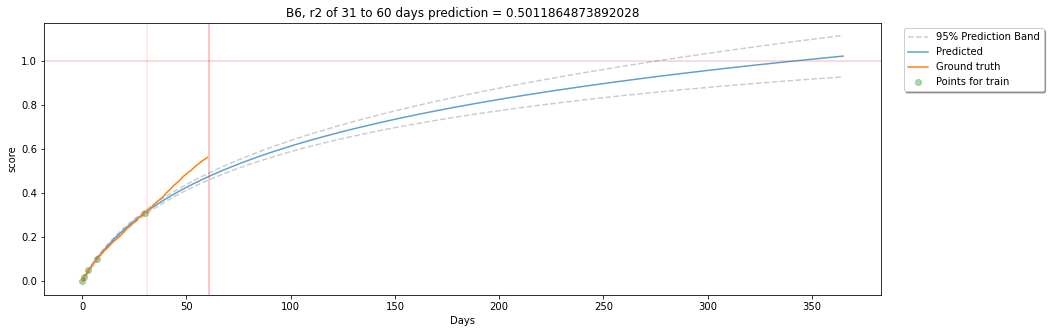

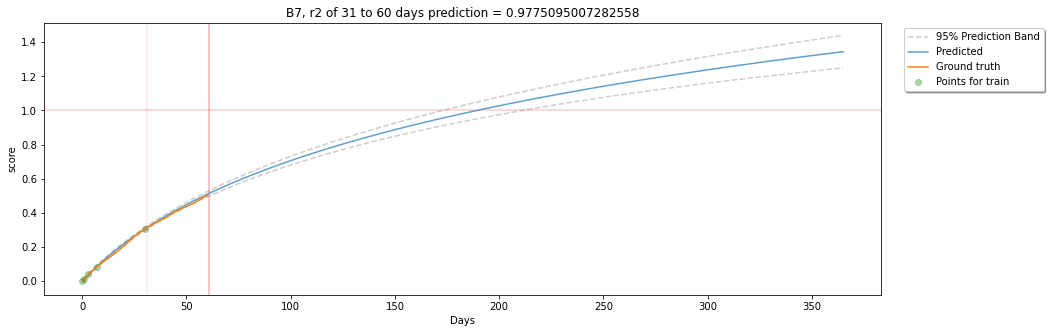

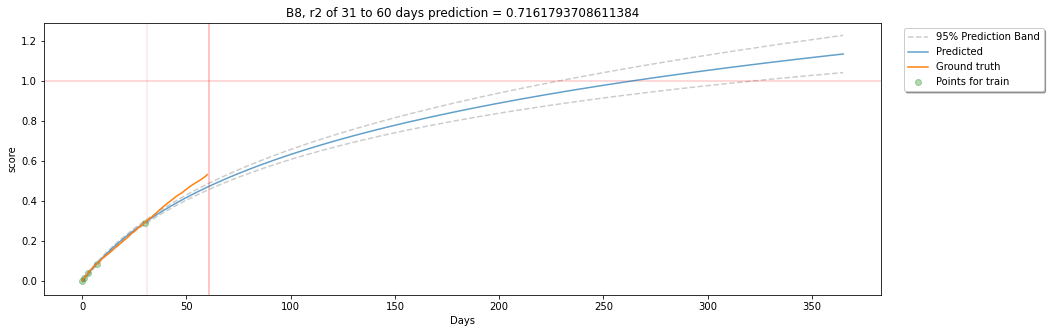

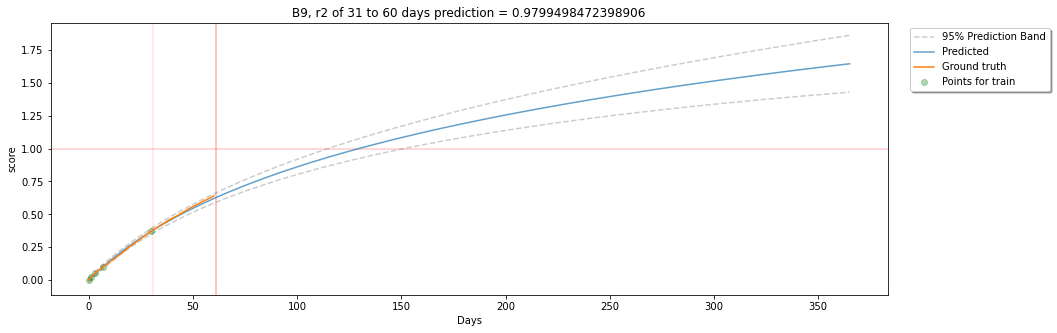

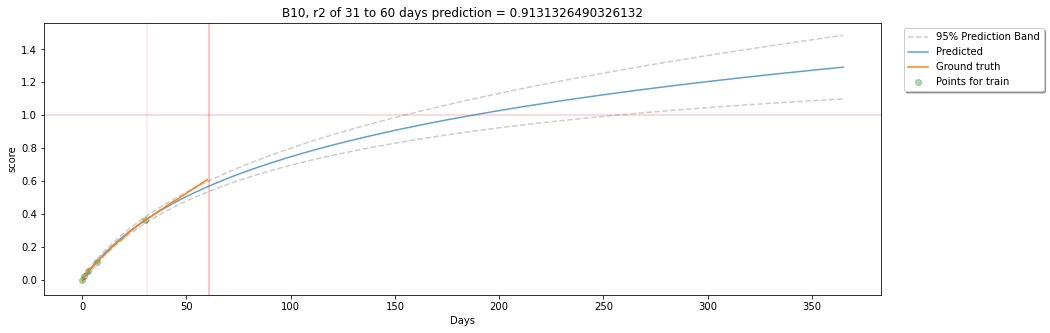

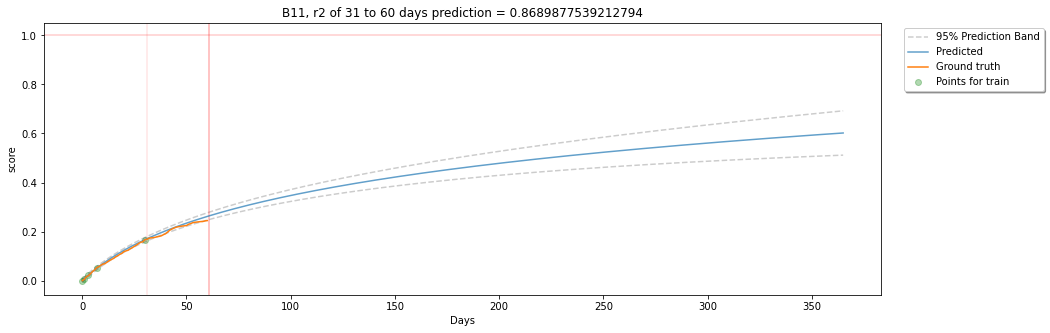

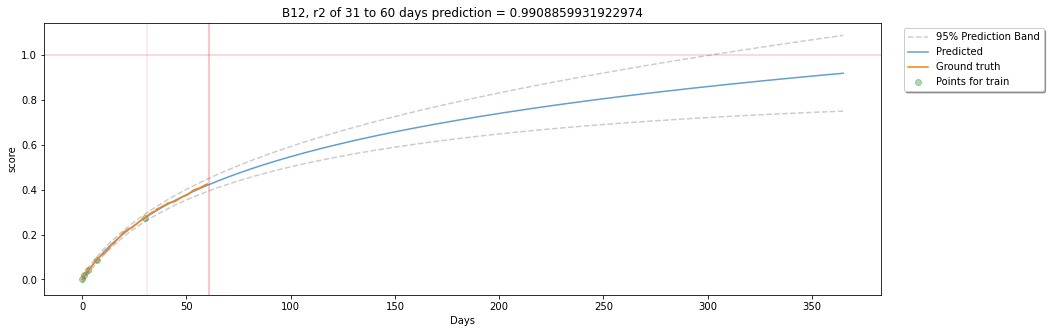

<IPython.core.display.Javascript object>

In [27]:
%%time

func = func_log
idxs_for_train = [0, 1, 3, 7, 30] # доопределим функцию в точке 0, потому что можем!
for feature in features:
    plot_predictions(feature=feature, func=func, train_days_len=31, dict_vals=dict_roases,idxs_for_train=idxs_for_train, desired_value=1.0)